In [1]:
x=1

In [2]:
# following https://github.com/mousepixels/sanbomics_scripts/blob/main/GO_in_python.ipynb
# accessed on 24 May 2024

In [3]:
# first need to make background gene set

# https://www.ncbi.nlm.nih.gov/gene
# "9606"[Taxonomy ID] AND alive[property] AND genetype protein coding[Properties]
# human

# send to file -> gene_result.txt

In [2]:
# !python /lustre/groups/ml01/workspace/anastasia.litinetskaya/mambaforge/envs/multimil/bin/ncbi_gene_results_to_python.py -o genes_ncbi_human_proteincoding.py gene_result.txt

      20,629 lines READ:  gene_result.txt
      20,608 geneids WROTE: genes_ncbi_human_proteincoding.py


In [5]:
from genes_ncbi_human_proteincoding import GENEID2NT as GeneID2nt_human

In [46]:
import pandas as pd
from goatools.base import download_go_basic_obo
from goatools.base import download_ncbi_associations
from goatools.obo_parser import GODag
from goatools.anno.genetogo_reader import Gene2GoReader
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS

In [47]:
#run one time to initialize
obo_fname = download_go_basic_obo()

  EXISTS: go-basic.obo


In [48]:
# !wget https://ftp.ncbi.nlm.nih.gov/gene/DATA/gene2go.gz
# gzip -d gene2go.gz 

In [49]:
fin_gene2go = 'gene2go'

In [50]:
obodag = GODag("go-basic.obo")

go-basic.obo: fmt(1.2) rel(2024-04-24) 45,667 Terms


In [51]:
#run one time to initialize
mapper = {}

for key in GeneID2nt_human:
    mapper[GeneID2nt_human[key].Symbol] = GeneID2nt_human[key].GeneID
    
inv_map = {v: k for k, v in mapper.items()}

In [52]:
#run one time to initialize

# Read NCBI's gene2go. Store annotations in a list of namedtuples
objanno = Gene2GoReader(fin_gene2go, taxids=[9606])
# Get namespace2association where:
#    namespace is:
#        BP: biological_process               
#        MF: molecular_function
#        CC: cellular_component
#    assocation is a dict:
#        key: NCBI GeneID
#        value: A set of GO IDs associated with that gene
ns2assoc = objanno.get_ns2assc()

HMS:0:01:09.066795 347,563 annotations, 20,771 genes, 18,739 GOs, 1 taxids READ: gene2go 


In [53]:
#run one time to initialize
goeaobj = GOEnrichmentStudyNS(
        GeneID2nt_human.keys(), # List of mouse protein-coding genes
        ns2assoc, # geneid/GO associations
        obodag, # Ontologies
        propagate_counts = False,
        alpha = 0.1, # default significance cut-off
        methods = ['fdr_bh']) # defult multipletest correction method


Load BP Ontology Enrichment Analysis ...
 83% 17,025 of 20,608 population items found in association

Load CC Ontology Enrichment Analysis ...
 88% 18,160 of 20,608 population items found in association

Load MF Ontology Enrichment Analysis ...
 85% 17,614 of 20,608 population items found in association


In [54]:
#run one time to initialize
GO_items = []

temp = goeaobj.ns2objgoea['BP'].assoc
for item in temp:
    GO_items += temp[item]
    

temp = goeaobj.ns2objgoea['CC'].assoc
for item in temp:
    GO_items += temp[item]
    

temp = goeaobj.ns2objgoea['MF'].assoc
for item in temp:
    GO_items += temp[item]

In [55]:
#pass list of gene symbols
def go_it(test_genes):
    print(f'input genes: {len(test_genes)}')
    
    mapped_genes = []
    for gene in test_genes:
        try:
            mapped_genes.append(mapper[gene])
        except:
            print(f'{gene} is not in the mapper.')
            pass
    print(f'mapped genes: {len(mapped_genes)}')
    
    goea_results_all = goeaobj.run_study(mapped_genes, alpha=0.1)
    goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.1]
    GO = pd.DataFrame(list(map(lambda x: [x.GO, x.goterm.name, x.goterm.namespace, x.p_uncorrected, x.p_fdr_bh,\
                   x.ratio_in_study[0], x.ratio_in_study[1], GO_items.count(x.GO), list(map(lambda y: inv_map[y], x.study_items)),\
                   ], goea_results_sig)), columns = ['GO', 'term', 'class', 'p', 'p_corr', 'n_genes',\
                                                    'n_study', 'n_go', 'study_genes'])

    GO = GO[GO.n_genes > 1]
    return GO

In [56]:
ipf_macrophages_multimil_up = [
    # multimil up only
    "SLAMF7",
    "CCL22",
    "CCND1",
    "TNFSF14",
    "CRABP2",
    "ZNF385D",
    "SPON2",
    "SPINK1",
    "CKB",
    "MMP2",
    # intersection
    "MATK", # ENSG00000007264
    "TIMP3", # ENSG00000100234
    "MMP9", # ENSG00000100985
    "SPP1", # ENSG00000118785
    "CHI3L1", # ENSG00000133048
    "MMP7", # ENSG00000137673
]

In [57]:
df = go_it(ipf_macrophages_multimil_up)

input genes: 16
mapped genes: 16

Runing BP Ontology Analysis: current study set of 16 IDs.
 94%     15 of     16 study items found in association
100%     16 of     16 study items found in population(20608)
Calculating 12,153 uncorrected p-values using fisher_scipy_stats
  12,153 terms are associated with 17,025 of 20,608 population items
     185 terms are associated with     15 of     16 study items
  METHOD fdr_bh:
       4 GO terms found significant (< 0.1=alpha) (  4 enriched +   0 purified): statsmodels fdr_bh
       4 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)

Runing CC Ontology Analysis: current study set of 16 IDs.
100%     16 of     16 study items found in association
100%     16 of     16 study items found in population(20608)
Calculating 1,814 uncorrected p-values using fisher_scipy_stats
   1,814 terms are associated with 18,160 of 20,608 population items
      30 terms are associated with 

In [58]:
df

,GO,term,class,p,p_corr,n_genes,n_study,n_go,study_genes
0,GO:0030574,collagen catabolic process,biological_process,4.020131e-06,0.021637,3,16,41,"[MMP2, MMP7, MMP9]"
1,GO:0007566,embryo implantation,biological_process,4.649670e-06,0.021637,3,16,44,"[SPP1, MMP2, MMP9]"
2,GO:0022617,extracellular matrix disassembly,biological_process,5.341251e-06,0.021637,3,16,45,"[MMP2, MMP7, MMP9]"
3,GO:0071492,cellular response to UV-A,biological_process,3.095656e-05,0.094054,2,16,11,"[MMP2, MMP9]"
4,GO:0005615,extracellular space,cellular_component,4.960738e-07,0.000900,9,16,1859,"[CKB, TNFSF14, TIMP3, SPP1, CHI3L1, MMP2, MMP7..."
5,GO:0031012,extracellular matrix,cellular_component,1.575866e-05,0.014293,4,16,206,"[SPON2, MMP7, TIMP3, CHI3L1]"
6,GO:0070062,extracellular exosome,cellular_component,6.888850e-05,0.041655,8,16,2212,"[CKB, SPINK1, CRABP2, SPP1, CHI3L1, SPON2, MMP..."
7,GO:0008237,metallopeptidase activity,molecular_function,8.291126e-06,0.038330,3,16,52,"[MMP2, MMP7, MMP9]"
8,GO:0004175,endopeptidase activity,molecular_function,2.036220e-05,0.047067,3,16,70,"[MMP2, MMP7, MMP9]"


In [89]:
df['term'] = df['term'].map(str.capitalize)

In [90]:
df['per'] = df.n_genes/df.n_go
df['n_study_genes'] = df['study_genes'].map(len)

In [91]:
df = df[0:10]
df

,GO,term,class,p,p_corr,n_genes,n_study,n_go,study_genes,per,n_study_genes
4,GO:0005615,Extracellular space,cellular_component,4.960738e-07,0.000900,9,16,1859,"[CKB, TNFSF14, TIMP3, SPP1, CHI3L1, MMP2, MMP7...",0.004841,9
6,GO:0070062,Extracellular exosome,cellular_component,6.888850e-05,0.041655,8,16,2212,"[CKB, SPINK1, CRABP2, SPP1, CHI3L1, SPON2, MMP...",0.003617,8
5,GO:0031012,Extracellular matrix,cellular_component,1.575866e-05,0.014293,4,16,206,"[SPON2, MMP7, TIMP3, CHI3L1]",0.019417,4
0,GO:0030574,Collagen catabolic process,biological_process,4.020131e-06,0.021637,3,16,41,"[MMP2, MMP7, MMP9]",0.073171,3
1,GO:0007566,Embryo implantation,biological_process,4.649670e-06,0.021637,3,16,44,"[SPP1, MMP2, MMP9]",0.068182,3
2,GO:0022617,Extracellular matrix disassembly,biological_process,5.341251e-06,0.021637,3,16,45,"[MMP2, MMP7, MMP9]",0.066667,3
7,GO:0008237,Metallopeptidase activity,molecular_function,8.291126e-06,0.038330,3,16,52,"[MMP2, MMP7, MMP9]",0.057692,3
8,GO:0004175,Endopeptidase activity,molecular_function,2.036220e-05,0.047067,3,16,70,"[MMP2, MMP7, MMP9]",0.042857,3
3,GO:0071492,Cellular response to uv-a,biological_process,3.095656e-05,0.094054,2,16,11,"[MMP2, MMP9]",0.181818,2


In [112]:
df['term'].iloc[-1] = 'Cellular response to UV-A'
df

/tmp/ipykernel_3775363/309278565.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['term'].iloc[-1] = 'Cellular response to UV-A'


,GO,term,class,p,p_corr,n_genes,n_study,n_go,study_genes,per,n_study_genes
4,GO:0005615,Extracellular space,cellular_component,4.960738e-07,0.000900,9,16,1859,"[CKB, TNFSF14, TIMP3, SPP1, CHI3L1, MMP2, MMP7...",0.004841,9
6,GO:0070062,Extracellular exosome,cellular_component,6.888850e-05,0.041655,8,16,2212,"[CKB, SPINK1, CRABP2, SPP1, CHI3L1, SPON2, MMP...",0.003617,8
5,GO:0031012,Extracellular matrix,cellular_component,1.575866e-05,0.014293,4,16,206,"[SPON2, MMP7, TIMP3, CHI3L1]",0.019417,4
0,GO:0030574,Collagen catabolic process,biological_process,4.020131e-06,0.021637,3,16,41,"[MMP2, MMP7, MMP9]",0.073171,3
1,GO:0007566,Embryo implantation,biological_process,4.649670e-06,0.021637,3,16,44,"[SPP1, MMP2, MMP9]",0.068182,3
2,GO:0022617,Extracellular matrix disassembly,biological_process,5.341251e-06,0.021637,3,16,45,"[MMP2, MMP7, MMP9]",0.066667,3
7,GO:0008237,Metallopeptidase activity,molecular_function,8.291126e-06,0.038330,3,16,52,"[MMP2, MMP7, MMP9]",0.057692,3
8,GO:0004175,Endopeptidase activity,molecular_function,2.036220e-05,0.047067,3,16,70,"[MMP2, MMP7, MMP9]",0.042857,3
3,GO:0071492,Cellular response to UV-A,biological_process,3.095656e-05,0.094054,2,16,11,"[MMP2, MMP9]",0.181818,2


In [61]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import seaborn as sns
import textwrap

In [113]:
df = df.sort_values(by='n_study_genes', ascending=False)

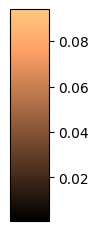

In [118]:
fig, ax = plt.subplots(figsize = (0.5, 2.75))

cmap = mpl.cm.copper
norm = mpl.colors.Normalize(vmin = df.p_corr.min(), vmax = df.p_corr.max())

mapper = cm.ScalarMappable(norm = norm, cmap = cm.copper)

cbl = mpl.colorbar.ColorbarBase(ax, cmap = cmap, norm = norm, orientation = 'vertical')
plt.savefig('figures/colorbar.svg', bbox_inches='tight')

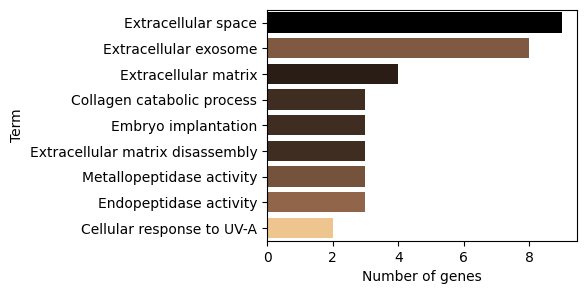

In [117]:
plt.figure(figsize = (4,3))
ax = sns.barplot(data = df, x = 'n_study_genes', y = 'term', palette = mapper.to_rgba(df.p_corr.values))
#ax.set_yticklabels([textwrap.fill(e, 22) for e in df['term']])
ax.set_xlabel('Number of genes')
ax.set_ylabel('Term')
plt.savefig('figures/barplot.svg', bbox_inches='tight')